In [1]:
import os
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import numpy as np

os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")

In [2]:
adata = sc.read_h5ad("cluster_files/adata_HT29_Dapagliflozin_balanced.h5ad")

In [3]:
# Rename original scores to preserve them
adata.obs.rename(columns={
    'G2M_score': 'G2M_score_original',
    'S_score': 'S_score_original',
    'phase': 'phase_original'
}, inplace=True)

In [4]:
# Load as a single column Series
genes = pd.read_csv("cluster_files/regev_lab_cell_cycle_genes.txt", header=None).squeeze()

# First 43 are S phase, rest are G2M
s_genes = genes[:43].tolist()
g2m_genes = genes[43:].tolist()

# Normalize and score cell cycle
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_2247/575835364.py:9: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:588: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


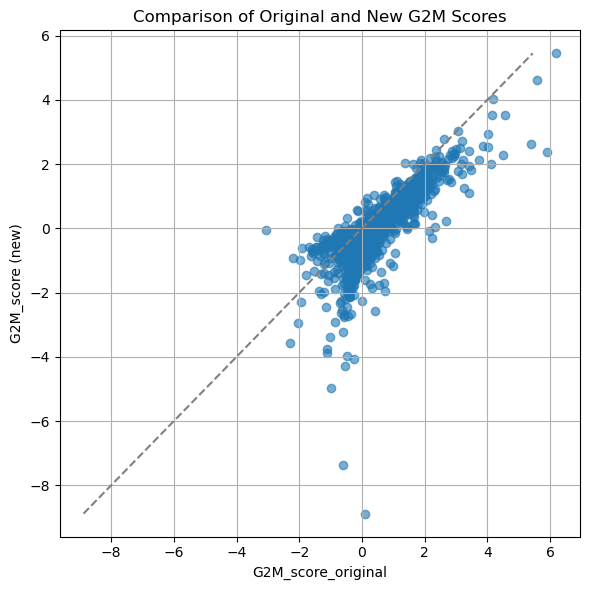

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    adata.obs['G2M_score_original'],
    adata.obs['G2M_score'],
    alpha=0.6
)
plt.xlabel('G2M_score_original')
plt.ylabel('G2M_score (new)')
plt.title('Comparison of Original and New G2M Scores')
plt.grid(True)
plt.tight_layout()
plt.plot([adata.obs['G2M_score'].min(), adata.obs['G2M_score'].max()],
         [adata.obs['G2M_score'].min(), adata.obs['G2M_score'].max()],
         linestyle='--', color='gray')  # identity line
plt.show()


In [6]:
score_angle = np.arctan2(adata.obs["G2M_score"], adata.obs["S_score"])
score_angle = np.mod(score_angle, 2 * np.pi)  # wrap to [0, 2π]

score_angle_original = np.arctan2(adata.obs["G2M_score_original"], adata.obs["S_score_original"])
score_angle_original = np.mod(score_angle_original, 2 * np.pi)  # wrap to [0, 2π]


# Store in obs
adata.obs["cycle_angle"] = score_angle
adata.obs["cycle_angle_original"] = score_angle_original


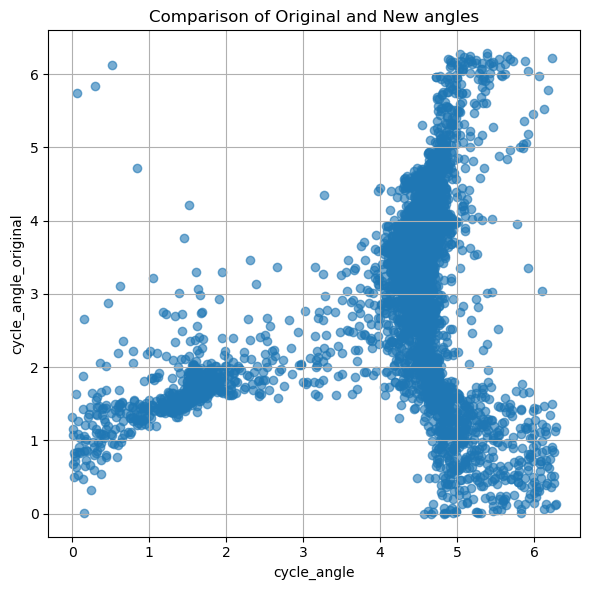

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(
    adata.obs['cycle_angle'],
    adata.obs['cycle_angle_original'],
    alpha=0.6
)
plt.xlabel('cycle_angle')
plt.ylabel('cycle_angle_original')
plt.title('Comparison of Original and New angles')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

def quantile_to_uniform_2pi(adata, angle_key, output_key, control_key="drugconc", control_value=0.0):
    n_cells = adata.n_obs

    # Select control cells to fit transformer
    control_mask = adata.obs[control_key] == control_value
    if control_mask.sum() == 0:
        raise ValueError(f"No cells found with {control_key} == {control_value}")

    control_angles = adata.obs.loc[control_mask, angle_key].values.reshape(-1, 1)
    all_angles = adata.obs[angle_key].values.reshape(-1, 1)

    # Check for NaNs
    if np.isnan(control_angles).any() or np.isnan(all_angles).any():
        raise ValueError(f"{angle_key} contains NaNs. Please clean or impute missing values.")

    # Fit on control, transform all
    qt = QuantileTransformer(
        output_distribution='uniform',
        random_state=0,
        n_quantiles=min(len(control_angles), 1000),
        subsample=len(control_angles)
    )
    qt.fit(control_angles)
    transformed = qt.transform(all_angles).flatten()
    adata.obs[output_key] = transformed * 2 * np.pi


In [11]:
quantile_to_uniform_2pi(
    adata,
    angle_key="cycle_angle_original",
    output_key="cycle_angle_uniform",
    control_key="drugconc",
    control_value=0.0
)


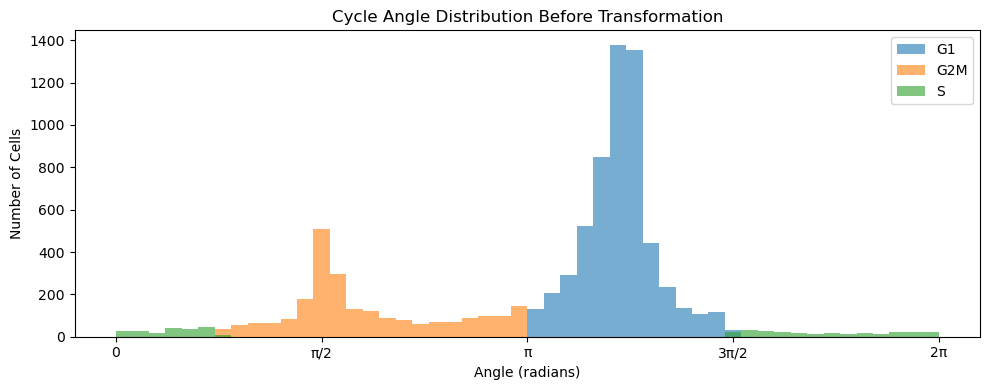

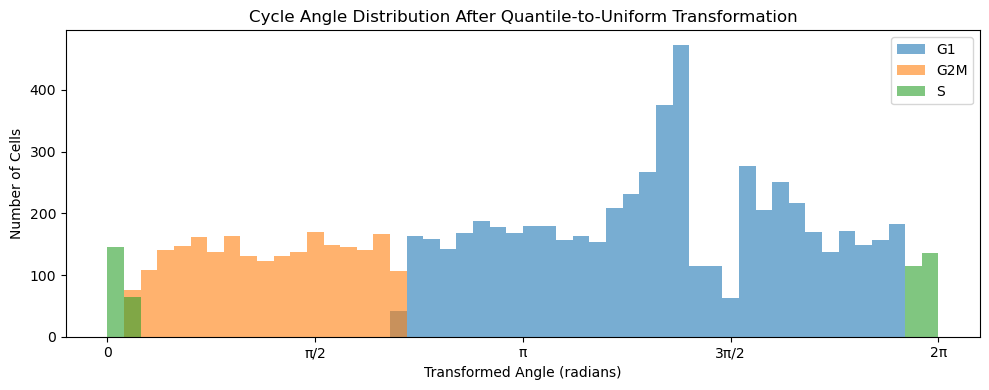

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
n_bins = 50
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
phases = adata.obs["phase_original"].values
unique_phases = np.unique(phases)
colors = plt.cm.tab10.colors

# Angles
angles_before = np.mod(adata.obs["cycle_angle_original"].values, 2 * np.pi)
angles_after = np.mod(adata.obs["cycle_angle_uniform"].values, 2 * np.pi)

# --- Plot BEFORE ---
plt.figure(figsize=(10, 4))
for i, phase in enumerate(unique_phases):
    mask = phases == phase
    plt.hist(
        angles_before[mask],
        bins=bin_edges,
        color=colors[i % len(colors)],
        alpha=0.6,
        label=phase
    )

plt.title("Cycle Angle Distribution Before Transformation")
plt.xlabel("Angle (radians)")
plt.ylabel("Number of Cells")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot AFTER ---
plt.figure(figsize=(10, 4))
for i, phase in enumerate(unique_phases):
    mask = phases == phase
    plt.hist(
        angles_after[mask],
        bins=bin_edges,
        color=colors[i % len(colors)],
        alpha=0.6,
        label=phase
    )

plt.title("Cycle Angle Distribution After Quantile-to-Uniform Transformation")
plt.xlabel("Transformed Angle (radians)")
plt.ylabel("Number of Cells")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend()
plt.tight_layout()
plt.show()



In [15]:
adata.write("cluster_files/adata_HT29_Dapagliflozin_balanced_cycle_angle.h5ad")